In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim


In [2]:
class ConvModule(nn.Module):
    def __init__(self):
        super(ConvModule, self).__init__()
        # 定义一个三层卷积
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64,kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Linear(128, 3)

    def forward(self, X):
        # 图片先经过三层卷积，输出维度(batch_size,C_out,H,W)
        out = self.conv(X)
        # 使用平均池化层将图片的大小变为1X1
        out = F.avg_pool2d(out, 26)
        # 将张量out从shape batch 128 x 1 x 1 x 1 变成  batch 128
        out = out.squeeze()
        # 输入到全连接层将输出的维度变为3
        out = self.fc(out)
        return out


In [3]:
device = torch.device("cuda")


In [4]:
# 数据增强 镜像操作/直方图均衡化
# car 779 truck 360 bus 218
import os
import cv2 as cv

bus_path = '/home/hatcher/test/deep-learning/VehicleDataset/bus'
car_path = '/home/hatcher/test/deep-learning/VehicleDataset/car'
truck_path = '/home/hatcher/test/deep-learning/VehicleDataset/truck'
bus_pics = os.listdir(bus_path)
car_pics = os.listdir(car_path)
truck_pics = os.listdir(truck_path)
bus_list, car_list, truck_list = [], [], []

for bus_pic in bus_pics:
    img = cv.imread(bus_path+"/"+bus_pic)
    img = cv.resize(img, (32, 32))
    flip_img = cv.flip(img, 1)
    equ_img = cv.equalizeHist(cv.cvtColor(img,cv.COLOR_BGR2GRAY))
    equ_img=cv.cvtColor(equ_img,cv.COLOR_GRAY2BGR)
    img = img/255
    bus_list.append(img)
    flip_img = flip_img/255
    bus_list.append(flip_img)
    equ_img = equ_img/255
    bus_list.append(equ_img)

for car_pic in car_pics:
    img = cv.imread(car_path+"/"+car_pic)
    img = cv.resize(img, (32, 32))
    img = img/255
    car_list.append(img)

for truck_pic in truck_pics:
    img = cv.imread(truck_path+"/"+truck_pic)
    img = cv.resize(img, (32, 32))
    flip_img = cv.flip(img, 1)
    img = img/255
    truck_list.append(img)
    flip_img = flip_img/255
    truck_list.append(flip_img)

In [5]:
#此时三种车的数据以FloatTensor的形式分别存放在三个列表中
print("bus_list length:",len(bus_list))
print("car_list length:",len(car_list))
print("truck_list length:",len(truck_list))

bus_list length: 654
car_list length: 779
truck_list length: 720


In [6]:
bus_length = len(bus_list)
car_length = len(car_list)
truck_length = len(truck_list)
num_bus_train = int(len(bus_list)*0.8)
num_car_train = int(len(car_list)*0.8)
num_truck_train = int(len(truck_list)*0.8)
train_y,test_y=[],[]
for i in range(num_bus_train):
    #train_y.append([1,0,0,0,0,0,0,0,0,0])
    train_y.append([1,0,0])
for i in range(num_car_train):
    #train_y.append([0,1,0,0,0,0,0,0,0,0])
    train_y.append([0,1,0])
for i in range(num_truck_train):
    #train_y.append([0,0,1,0,0,0,0,0,0,0])
    train_y.append([0,0,1])
for i in range(num_bus_train,bus_length):
    #test_y.append([1,0,0,0,0,0,0,0,0,0])
    test_y.append([1,0,0])
for i in range(num_car_train,car_length):
    #test_y.append([0,1,0,0,0,0,0,0,0,0])
    test_y.append([0,1,0])
for i in range(num_truck_train,truck_length):
    #test_y.append([0,0,1,0,0,0,0,0,0,0])
    test_y.append([0,0,1])
train_x,test_x=[],[]
for i in range(num_bus_train):
    train_x.append(bus_list[i])
for i in range(num_car_train):
    train_x.append(car_list[i])
for i in range(num_truck_train):
    train_x.append(truck_list[i])
for i in range(num_bus_train,bus_length):
    test_x.append(bus_list[i])
for i in range(num_car_train,car_length):
    test_x.append(car_list[i])
for i in range(num_truck_train,truck_length):
    test_x.append(truck_list[i])

train_x = torch.Tensor(train_x).permute(0,3,1,2)
test_x = torch.Tensor(test_x).permute(0,3,1,2)
train_y = torch.Tensor(train_y)
test_y = torch.Tensor(test_y)
print("train_x:",train_x.size())
print("test_x:",test_x.size())
print("train_y:",train_y.size())
print("test_y:",test_y.size())


/tmp/ipykernel_47012/1321487925.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  train_x = torch.Tensor(train_x).permute(0,3,1,2)


train_x: torch.Size([1722, 3, 32, 32])
test_x: torch.Size([431, 3, 32, 32])
train_y: torch.Size([1722, 3])
test_y: torch.Size([431, 3])


In [7]:
train_x = train_x[1:1701,:,:,:]
test_x = test_x[1:431,:,:,:]
train_y = train_y[1:1701,:]
test_y = test_y[1:431,:]
print("train_x:",train_x.size())
print("test_x:",test_x.size())
print("train_y:",train_y.size())
print("test_y:",test_y.size())

train_x: torch.Size([1700, 3, 32, 32])
test_x: torch.Size([430, 3, 32, 32])
train_y: torch.Size([1700, 3])
test_y: torch.Size([430, 3])


In [26]:
import torch.utils.data as Data
batch_size = 20# 将训练数据的特征和标签组合
train_dataset,test_dataset = Data.TensorDataset(train_x, train_y),Data.TensorDataset(test_x, test_y)
# 把 dataset 放入 DataLoader
train_iter = Data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=2)
test_iter = Data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True,num_workers=2)

In [9]:
def evaluate_accuracy(data_iter, net, loss):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        y_hat = y_hat.squeeze()
        #y_hat = y_hat.view(1,-1) 
        acc_sum += (y_hat.argmax(dim=1) == y.argmax(dim=1)).sum().item()
        l = loss(y_hat, y).sum()
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum/n, test_l_sum/n


In [10]:
def train(net,train_iter,test_iter,loss,num_epochs,batch_size,params=None,lr=None,optimizer=None):
    train_loss=[]
    test_loss=[]
    train_accuracy=[]
    test_accuracy=[]
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            y = y.to(device) #target (N)
            #print(y.size())
            y_hat = net(X)
            y_hat = y_hat.squeeze()# input (N,C) 
            #y_hat = y_hat.view(1,-1) 
            #print(y_hat.size())
            l=loss(y_hat,y).sum()
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                SGD(params,lr)
            else:
                optimizer.step()
            train_l_sum+=l.item()
            '''print(y_hat.shape)
            print(y.shape)
            print(y_hat)
            print(y_hat.argmax(dim=1))
            print(y)
            print(y_hat.argmax(dim=1)==y)
            '''
            train_acc_sum+=(y_hat.argmax(dim=1)==y.argmax(dim=1)).sum().item()
            n+=y.shape[0]
        test_acc,test_l = evaluate_accuracy(test_iter,net,loss)
        train_loss.append(train_l_sum/n)
        test_loss.append(test_l)
        train_accuracy.append(train_acc_sum/n)
        test_accuracy.append(test_acc)
        print('epoch%d,loss%.4f,train acc %3f,test acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,test_acc))
    return train_loss,test_loss,train_accuracy,test_accuracy

In [16]:
num_epochs=50
lr=0.1
loss=nn.CrossEntropyLoss()

In [27]:
net = ConvModule()
net.to(device)
optimizer=optim.SGD(net.parameters(),lr)
for params in net.parameters():
    nn.init.normal_(params,mean=0,std=0.01)

In [14]:
a = torch.tensor([[0.0258,-0.0033,0.0216],[0.0258,-0.0033,0.0216]])
a.argmax(dim=1)

tensor([0, 0])

In [28]:
train_loss,test_loss,train_accuracy,test_accuracy=train(net,train_iter,test_iter,loss,num_epochs,batch_size,net.parameters(),lr,optimizer)

epoch1,loss0.0549,train acc 0.361765,test acc 0.363
epoch2,loss0.0548,train acc 0.366471,test acc 0.363
epoch3,loss0.0546,train acc 0.366471,test acc 0.363
epoch4,loss0.0521,train acc 0.473529,test acc 0.628
epoch5,loss0.0455,train acc 0.667647,test acc 0.649
epoch6,loss0.0381,train acc 0.712353,test acc 0.779
epoch7,loss0.0312,train acc 0.782353,test acc 0.805
epoch8,loss0.0300,train acc 0.764706,test acc 0.800
epoch9,loss0.0272,train acc 0.802941,test acc 0.781
epoch10,loss0.0241,train acc 0.836471,test acc 0.844
epoch11,loss0.0224,train acc 0.835294,test acc 0.714
epoch12,loss0.0195,train acc 0.871765,test acc 0.840
epoch13,loss0.0194,train acc 0.866471,test acc 0.865
epoch14,loss0.0186,train acc 0.865882,test acc 0.891
epoch15,loss0.0165,train acc 0.888235,test acc 0.874
epoch16,loss0.0174,train acc 0.873529,test acc 0.888
epoch17,loss0.0161,train acc 0.888824,test acc 0.891
epoch18,loss0.0156,train acc 0.889412,test acc 0.900
epoch19,loss0.0156,train acc 0.887647,test acc 0.879
ep

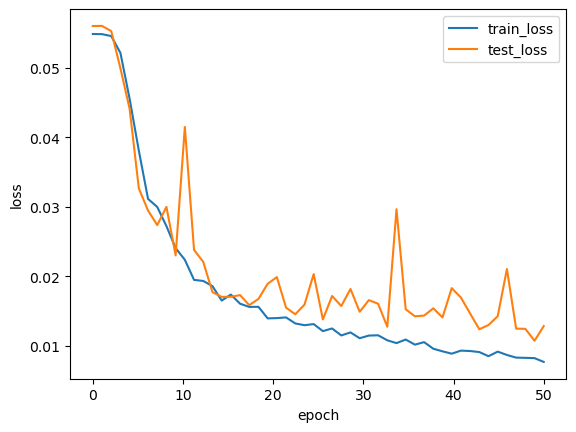

In [29]:
import matplotlib.pyplot as plt
import numpy as np
x=np.linspace(0,len(train_loss),len(train_loss))
plt.plot(x,train_loss,label='train_loss',linewidth=1.5)
plt.plot(x,test_loss,label='test_loss',linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

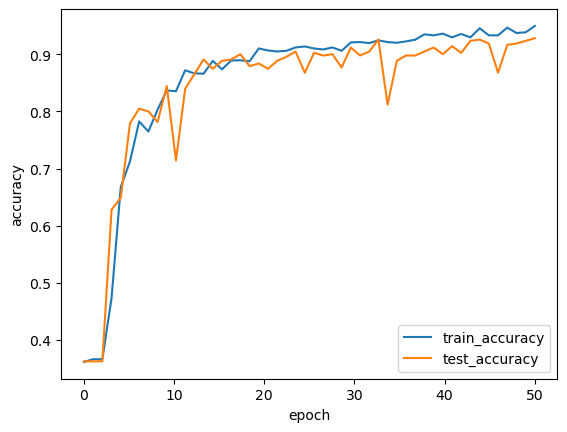

In [30]:
x=np.linspace(0,len(train_accuracy),len(train_accuracy))
plt.plot(x,train_accuracy,label='train_accuracy',linewidth=1.5)
plt.plot(x,test_accuracy,label='test_accuracy',linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()